In [1]:
from matplotlib import pyplot
import numpy
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

In [2]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import TimeSeries
from pyfoomb import ParameterMapper
from pyfoomb import Helpers

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [3]:
# Helper function for this notebook
def investigate_last_values(positions:int, time_series:list, name:str, replicate_id:str=None):
    
    # Use pyFOOMB Helper method to extract the TimeSeries object
    _time_series = Helpers.extract_time_series(time_series, name=name, replicate_id=replicate_id)
    
    # Get the last positions of the corresponding values vector
    last_values = _time_series.values[-1*positions:]
    print(f'\nThe last {positions} values:')
    print(last_values)

    # Visualize these values
    fig, ax = pyplot.subplots(dpi=100)
    _x = range(-1*positions, 0)
    ax.bar(x=_x, height=last_values)
    ax.plot(_x, last_values, color='black', marker='.', linestyle=':')
    ax.set_xticks(_x)
    ax.set_ylim(min(last_values)*1.1, max(last_values)*1.1)
    ax.set_ylabel(_time_series.name)
    ax.set_xlabel('Position in TimeSeries value vector')
    ax.set_title(str(_time_series))
    fig.tight_layout()

# Non-negativity of model states

Sometimes one need to enforce the non-negativity of model states to avoid non-pysiological values (concentrations cannot be negative).

Because the numeric integration of ODE systems is prone to unavoidable numerical errors since this is done on a machine with endless precision. From this fact, we'll see for a simple Monod model how values for substrate concentrations are very close around zero in the stationary phase.

# Example bioprocess model

In [4]:
# Defines the model class
class MonodGrowth(BioprocessModel):       
    
    def specific_growth_rate_mu(self, S):
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (S + kS)
        return mu
    
    def specific_substrate_consumption_rate_qS(self, mu):
        YXS = self.model_parameters['YXS']
        qS = 1/YXS * mu
        return qS
    
    def rhs(self, t, y, sw=None):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(S)
        qS = self.specific_substrate_consumption_rate_qS(mu)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        
        # Return derivatives in the correct order
        return [dSdt, dXdt]
    
    def get_specific_rates_time_series(self, model_states:list):
        
        # Use the pyFOOMB Helpers method to get a specific TimeSeries object, specified by its `name` and `replicate_id`
        state_S = Helpers.extract_time_series(model_states, name='S', replicate_id=self.replicate_id)
        
        # Get the timepoints and values needed for specific rate calculation
        _t = state_S.timepoints
        _S = state_S.values
        
        # Calculate specific rates vectors
        _mu = self.specific_growth_rate_mu(_S)
        _qS = self.specific_substrate_consumption_rate_qS(_mu)
        
        # Create new corresponding TimeSeries objects
        mu = TimeSeries(name='mu', replicate_id=self.replicate_id, timepoints=_t, values=_mu)
        qS = TimeSeries(name='qS', replicate_id=self.replicate_id, timepoints=_t, values=_qS)
        
        return [mu, qS]

In [5]:
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
}

As usual, create a `Caretaker` instance and run a forward simulation.

In [6]:
# Instantiates are caretaker
caretaker_1 = Caretaker(
    bioprocess_model_class=MonodGrowth, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

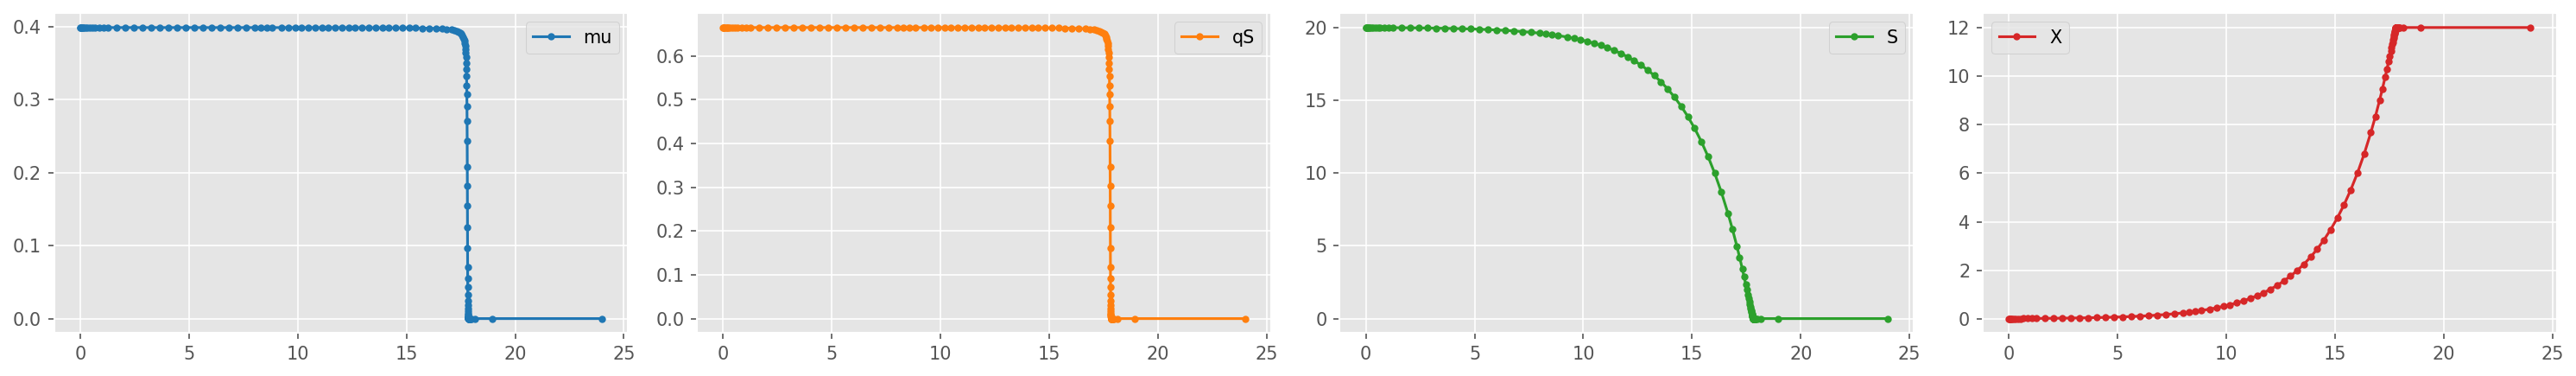

In [7]:
simulation = caretaker_1.simulate(t=24)

# Now calculate all specific rates TimeSeries objects
specific_rates = []
for rid in caretaker_1.replicate_ids:
    specific_rates.extend(
        caretaker_1.simulators[rid].bioprocess_model.get_specific_rates_time_series(simulation)
    )
    
simulation_extended = [*simulation, *specific_rates]

_ = Visualization.show_kinetic_data(simulation_extended, ncols=4)

 Now let's have a detailed look at the few last values of the model state `S`and the derived specific rate `mu`.
 
 We can see that these last values are very close to zero, but do actually undershoot and then come back to zero.


The last 10 values:
[ 3.81083064e-07 -2.89075725e-08 -1.01754547e-07 -7.74599343e-08
 -4.00162592e-08 -6.89444408e-09 -7.43634766e-10 -2.81897128e-11
 -1.66429003e-13  2.27643343e-15]


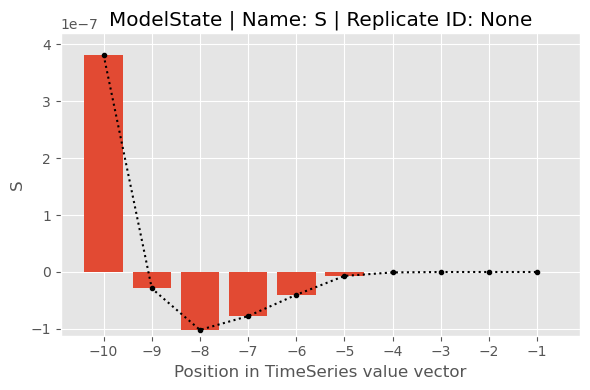

In [8]:
investigate_last_values(10, simulation_extended, 'S')


The last 10 values:
[ 3.04864128e-06 -2.31260714e-07 -8.14038036e-07 -6.19680434e-07
 -3.20130330e-07 -5.51555602e-08 -5.94907822e-09 -2.25517703e-10
 -1.33143202e-12  1.82114674e-14]


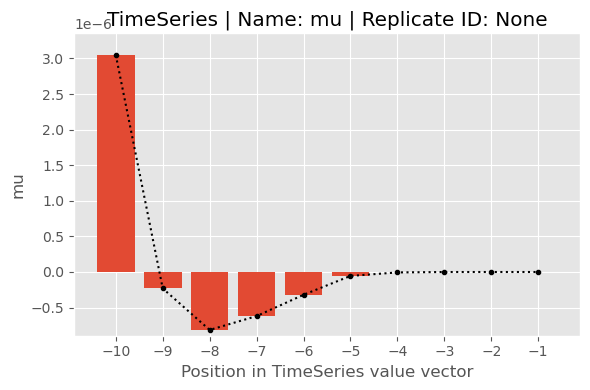

In [9]:
investigate_last_values(10, simulation_extended, 'mu')

# Enforcing non-negative states using event detection

By additionally implementing the methods `state_events` and `change_states` we can check for (unwanted) negative states and then replace these with 0.

In [10]:
# Defines the model class
class MonodGrowthNonNegative(MonodGrowth):
    
    def state_events(self, t, y, sw):
        S, X = y
        return [S, X]
    
    def change_states(self, t, y, sw):
        S, X = y
        if sw[0]:
            S = 0.0
        if sw[1]:
            X = 0.0
        return [S, X]

In [11]:
caretaker_2 = Caretaker(
    bioprocess_model_class=MonodGrowthNonNegative, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

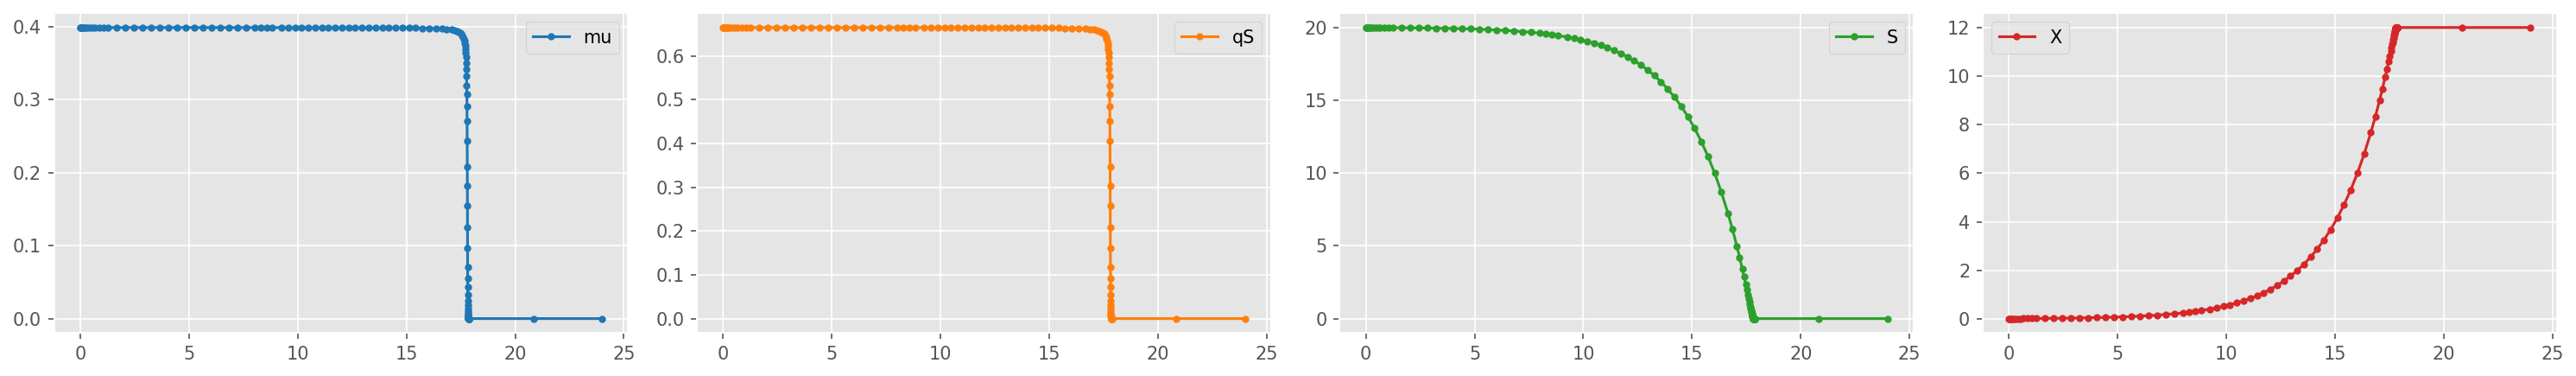

In [12]:
simulation = caretaker_2.simulate(t=24)

# Now calculate all specific rates TimeSeries objects
specific_rates = []
for rid in caretaker_2.replicate_ids:
    specific_rates.extend(
        caretaker_2.simulators[rid].bioprocess_model.get_specific_rates_time_series(simulation)
    )
    
simulation_extended = [*simulation, *specific_rates]

_ = Visualization.show_kinetic_data(simulation_extended, ncols=4)

The detailed look at the last values shows the effect of the implemented event handling methods.

NOTE: We observe a single negative value which is extremely close to zero. This value is below the machine precision, which means that the addition of this value to another number has no effect, more specifically, is behaves like a zero for additions and substractions, i.e. n + x = n.


The last 10 values:
[ 1.48784330e-05  8.50094798e-06  5.56426575e-06  3.35549251e-06
  1.66549794e-06  3.81083064e-07 -1.75475779e-18  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


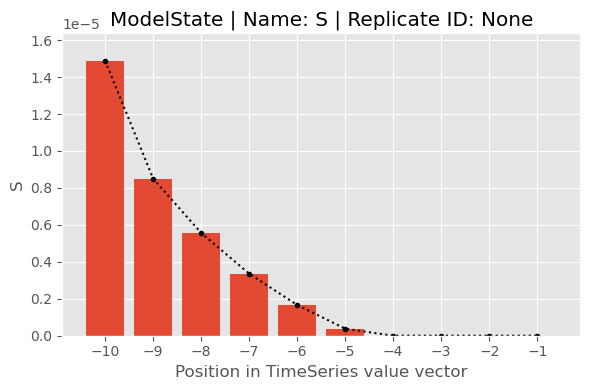

In [13]:
investigate_last_values(10, simulation_extended, 'S')


The last 10 values:
[ 1.18992056e-04  6.79960233e-05  4.45091728e-05  2.68421387e-05
  1.33235397e-05  3.04864128e-06 -1.40380623e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


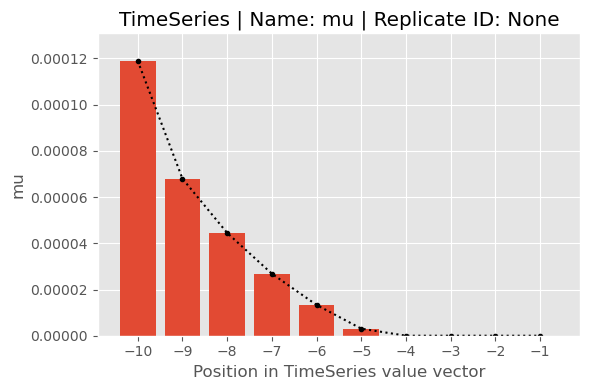

In [14]:
investigate_last_values(10, simulation_extended, 'mu')